In [1]:
import torch
from protoclr_obow import PCLROBoW
from omegaconf import OmegaConf
OmegaConf.register_resolver("uuid", lambda : "123")
from dataloaders import UnlabelledDataset, UnlabelledDataModule
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import einops
import os
import h5py
import numpy as np
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import einops
sns.set_theme()
%matplotlib inline
%load_ext autoreload

/tmp/ipykernel_45678/3718102619.py:4: UserWarning: register_resolver() is deprecated.
See https://github.com/omry/omegaconf/issues/426 for migration instructions.

  OmegaConf.register_resolver("uuid", lambda : "123")


In [2]:
%autoreload 2

In [3]:
model = PCLROBoW.load_from_checkpoint("ckpts/cnn.ckpt").to("cuda")

MultiHeadDotProduct


/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [4]:
from save_features import LabelledDataset, save_features

In [5]:
conf = OmegaConf.load("configs/local/edge.yml")["data"]

In [6]:
train_classes = ["n02687172", "n04251144", "n02823428", "n03676483", "n03400231"]
test_classes = ["n03272010", "n07613480", "n03775546", "n03127925", "n04146614"]
trainset = LabelledDataset('miniimagenet', conf["datapath"],
                           'train', train_classes)
testset = LabelledDataset('miniimagenet', conf["datapath"],
                          'test', test_classes)
trainloader = DataLoader(trainset, shuffle=False, batch_size=100)
testloader = DataLoader(testset, shuffle=False, batch_size=100)

In [7]:
save_features(model.feature_extractor, trainloader, "onlycnn.hdf5")

0/30
10/30
20/30


In [8]:
save_features(model, trainloader, "cnn_gnn.hfd5", gnn=torch.load("ckpts/cnn.ckpt"))

0/30
10/30
20/30


In [9]:
save_features(model.feature_extractor, testloader, "Test_onlycnn.hdf5")

0/30
10/30
20/30


In [10]:
save_features(model, testloader, "Test_cnn_gnn.hfd5", gnn=torch.load("ckpts/cnn.ckpt"))

0/30
10/30
20/30


## Plots

In [11]:
f_train_cnn = h5py.File('onlycnn.hdf5', 'r')
f_test_cnn = h5py.File('Test_onlycnn.hdf5', 'r')

In [12]:
X_cnn_5_train = f_train_cnn['all_feats']
y_cnn_5_train = f_train_cnn['all_labels']
X_cnn_5_test = f_test_cnn['all_feats']
y_cnn_5_test = f_test_cnn['all_labels']

In [13]:
import random

In [14]:
train_protoclr_idx = random.sample(range(len(y_cnn_5_train)),500)
train_protoclr_idx.sort()

X_cnn_5_train = X_cnn_5_train[train_protoclr_idx]
y_cnn_5_train = y_cnn_5_train[train_protoclr_idx]

test_protoclr_idx = random.sample(range(len(y_cnn_5_test)),500)
test_protoclr_idx.sort()

X_cnn_5_test = X_cnn_5_test[test_protoclr_idx]
y_cnn_5_test = y_cnn_5_test[test_protoclr_idx]

In [15]:
um = umap.UMAP(n_components=2, random_state=0)
X_cnn_2d_train = um.fit_transform(einops.rearrange(X_cnn_5_train, "b c h w -> b (c h w)"))

In [16]:
um = umap.UMAP(n_components=2, random_state=0)
X_cnn_2d_test = um.fit_transform(einops.rearrange(X_cnn_5_test, "b c h w -> b (c h w)"))

In [17]:
def plot2d(X_2d, y,colors=None, title=None, save_as=None):
    target_ids = range(5)
    labels_train = ["Class {}".format(i) for i in range(1,6)]

    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(11.7,8.27))
    ax = fig.add_subplot(111)
    #colors = 'r', 'g', 'b', 'c', 'm'#, 'y', 'k', 'w', 'orange', 'purple'
    
    markers = "o","D","*","^","P"
    #print(len(colors))
    for i, c, label, marker in zip(target_ids, colors, labels_train, markers):
        ax.scatter(X_2d[y == i, 0],
                   X_2d[y == i, 1], 
                   c=c, label=label, marker=marker)
    #plt.legend()
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(left=True, bottom=True)
    #plt.legend(loc='lower right')
    if save_as:
        plt.savefig(save_as, bbox_inches = 'tight',
            pad_inches = 0)
    if title:
        plt.title(title)
    plt.show()

In [18]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

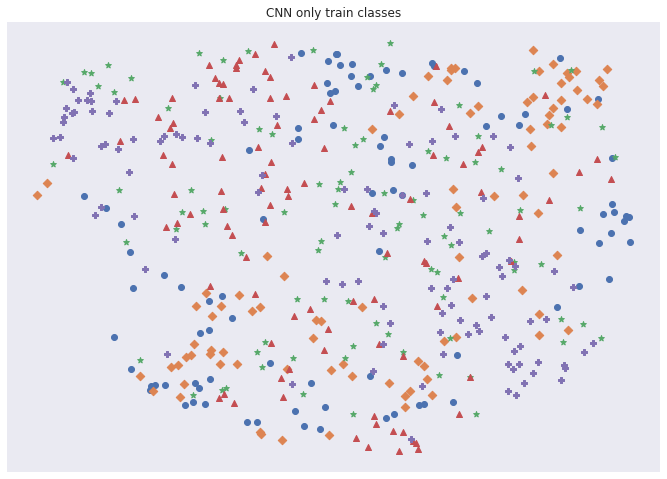

In [19]:
plot2d(X_2d=X_cnn_2d_train, 
       y=y_cnn_5_train,
       colors=colors[:5],
       title="CNN only train classes")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

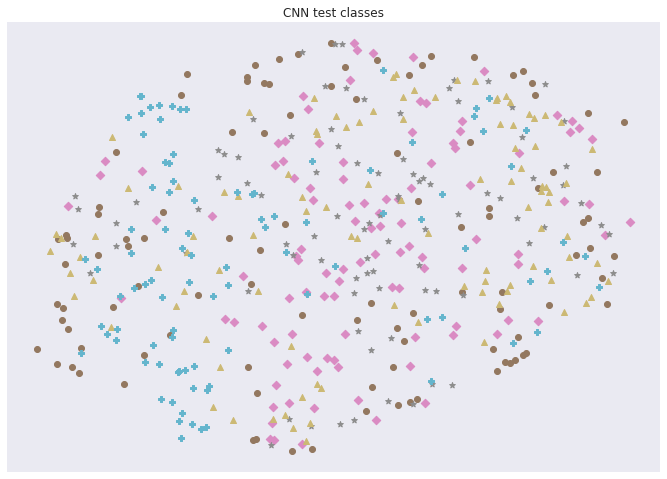

In [20]:
plot2d(X_2d=X_cnn_2d_test, 
       y=y_cnn_5_test,
       colors=colors[5:],
       title="CNN test classes")

In [21]:
f_train_cnn_gnn = h5py.File('cnn_gnn.hfd5', 'r')
f_test_cnn_gnn = h5py.File('Test_cnn_gnn.hfd5', 'r')

In [22]:
X_cnn_gnn_5_train = f_train_cnn_gnn['all_feats']
y_cnn_gnn_5_train = f_train_cnn_gnn['all_labels']
X_cnn_gnn_5_test = f_test_cnn_gnn['all_feats']
y_cnn_gnn_5_test = f_test_cnn_gnn['all_labels']

In [23]:
train_protoclr_idx = random.sample(range(len(y_cnn_gnn_5_train)),500)
train_protoclr_idx.sort()

X_cnn_gnn_5_train = X_cnn_gnn_5_train[train_protoclr_idx]
y_cnn_gnn_5_train = y_cnn_gnn_5_train[train_protoclr_idx]

test_protoclr_idx = random.sample(range(len(y_cnn_gnn_5_test)),500)
test_protoclr_idx.sort()

X_cnn_gnn_5_test = X_cnn_gnn_5_test[test_protoclr_idx]
y_cnn_gnn_5_test = y_cnn_gnn_5_test[test_protoclr_idx]

In [24]:
um = umap.UMAP(n_components=2, random_state=0)
X_cnn_gnn_2d_train = um.fit_transform(X_cnn_gnn_5_train)

In [25]:
um = umap.UMAP(n_components=2, random_state=0)
X_cnn_gnn_2d_test = um.fit_transform(X_cnn_gnn_5_test)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

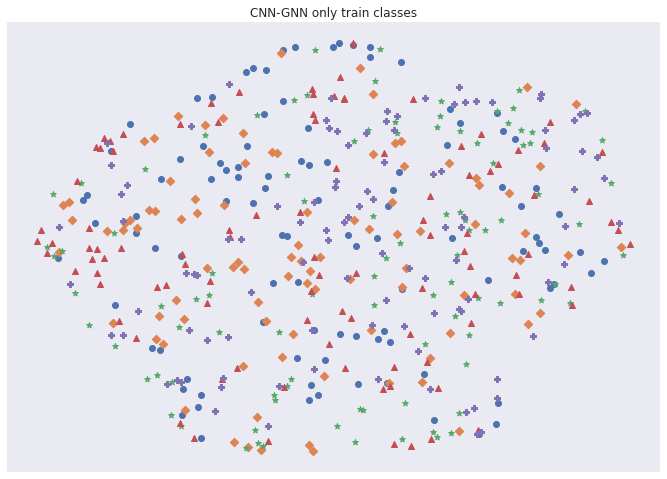

In [26]:
plot2d(X_2d=X_cnn_gnn_2d_train, 
       y=y_cnn_gnn_5_train,
       colors=colors[:5],
       title="CNN-GNN only train classes")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

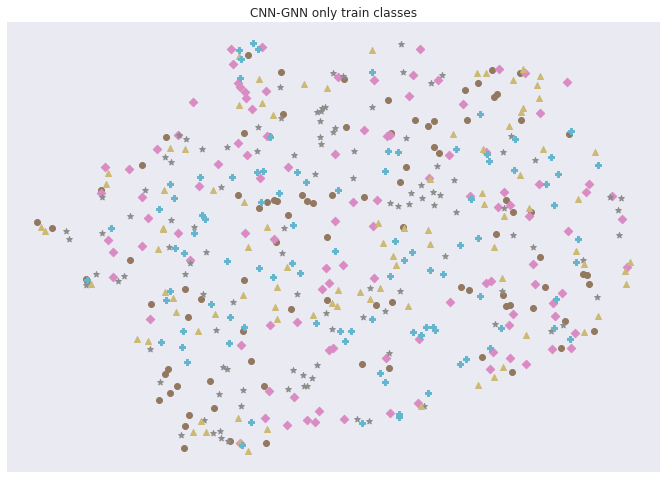

In [28]:
plot2d(X_2d=X_cnn_gnn_2d_test, 
       y=y_cnn_gnn_5_test,
       colors=colors[5:],
       title="CNN-GNN only train classes")